In [1]:
import os
import cv2
import glob
import torch
import datetime
import numpy as np
from PIL import Image
import torch.nn as nn
import albumentations as A
from torch import from_numpy
import torch.nn.functional as F
from torch.nn import DataParallel
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from torch.nn import CrossEntropyLoss
from torch.optim import SGD, Adam, lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary

In [5]:
# Data path
INPUT_PATH = './segdata128/reduced'
INPUT_PATH_MASK = './segdata128/reduced_mask'

In [6]:
INPUT_IMG_SIZE = 128
OUTPUT_CLASSES = 12
LEARINING_RATE = 0.003
OPIMIZER_NAME = 'Adam'
SCHEDULER_NAME = 'stepLR'
BATCH_SIZE = 8
MAX_EPOCHS = 25
AUGMENTATION = False
MEAN = None
STD = None
THRESH_ACC_CKP = 0.35
SCHEDULER_STEP_SIZE = 4
USE_CUDA = torch.cuda.is_available()

In [7]:
USE_CUDA

True

In [8]:
train_files = glob.glob(os.path.join(INPUT_PATH + '/train', '*jpg'))
train_files_mask = glob.glob(os.path.join(INPUT_PATH_MASK + '/train', '*jpg'))
test_files = glob.glob(os.path.join(INPUT_PATH + '/val', '*jpg'))
test_files_mask = glob.glob(os.path.join(INPUT_PATH_MASK + '/val', '*jpg'))

print('Total train images:', len(train_files))
print('Total train mask:', len(train_files_mask))

print('Total test images:', len(test_files))
print('Total test mask:', len(test_files_mask))

Total train images: 2975
Total train mask: 2975
Total test images: 500
Total test mask: 500


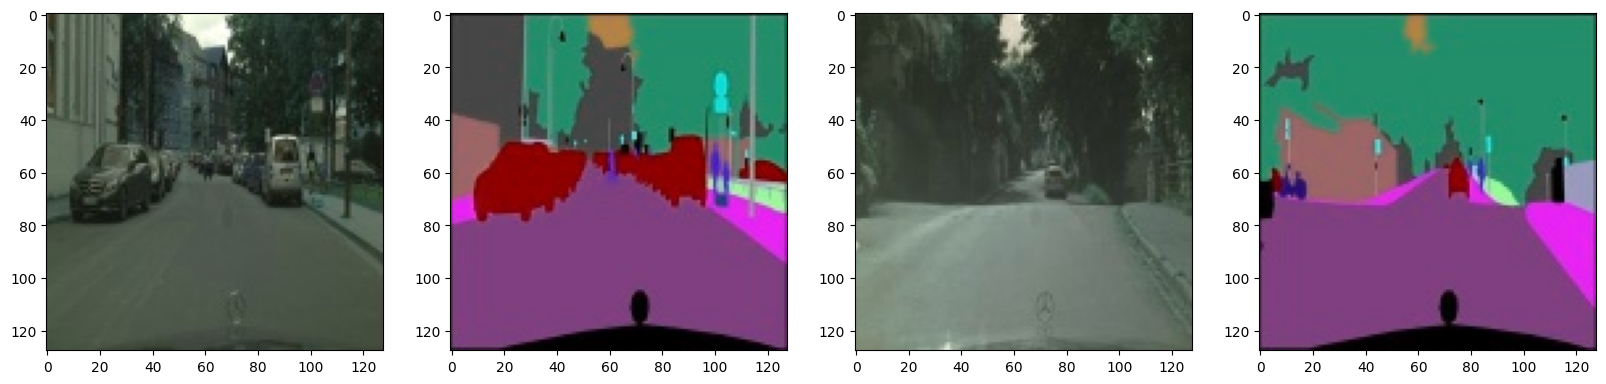

In [9]:
fig, axes = plt.subplots(1,4, figsize = (20,5))
for i, ax in enumerate(axes.ravel()):
    if(i%2==0):
      img = cv2.imread(train_files[i//2])
      ax.imshow(img)
    else:
      mk = cv2.imread(train_files_mask[i//2])
      ax.imshow(mk)
plt.show()

In [10]:
kmeans_data = []
for i in train_files_mask[:50]:
    org_img = cv2.imread(i)

    msk = org_img
    kmeans_data.append(msk)
kmeans_data = np.array(kmeans_data)
kmeans_data = kmeans_data.reshape(-1,3)

encoder = KMeans(n_clusters=OUTPUT_CLASSES, n_init=10, max_iter=200)
encoder.fit(kmeans_data)

KMeans(max_iter=200, n_clusters=12, n_init=10)

In [11]:
# save encoder as pickle file
import pickle
with open('encoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)

In [12]:
class SegDataset(Dataset):
    def __init__(self, encoder, img_size, images_list, mask_list, size, augmentation = False, mean = None, std = None):
        self.encoder = encoder
        self.images_list = images_list
        self.mask_list = mask_list
        self.size = size
        self.augmentation = augmentation
        self.img_size = img_size
        if mean is None or std is None:
            self.mean = [0., 0., 0.]
            self.std = [1., 1., 1.]
        else:
            self.mean = mean
            self.std = std

    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, index):
        pil_image = Image.open(self.images_list[index]).convert('RGB')
        pil_mask = Image.open(self.mask_list[index]).convert('RGB')
        pil_image = pil_image.resize((self.img_size, self.img_size))
        pil_mask = pil_mask.resize((self.img_size, self.img_size))

        np_image = np.array(pil_image)
        np_target = np.array(pil_mask)


        test = (np_target.reshape(-1,3))
        pred = self.encoder.predict(test)
        
        seg_msk = pred.reshape(self.size,self.size)

        if self.augmentation:
            trans_obj = A.Compose([A.Resize(self.size, self.size),
                           A.Rotate(25, border_mode=4, p=0.7),
                           A.Normalize(self.mean, self.std)
                          ])
            noise_trans = A.GaussNoise(var_limit=(10.0, 50.0), p=0.7)

        else:
            trans_obj = A.Compose([A.Resize(self.size, self.size),
                                   A.Normalize(self.mean, self.std)])
        if self.augmentation:
            np_image = noise_trans(image = np_image)['image']
        transformed = trans_obj(image = np_image, mask = seg_msk)
        img_tensor = from_numpy(transformed['image']).permute(2, 0, 1)
        mask_tensor = from_numpy(transformed['mask'])
        return img_tensor, mask_tensor


In [13]:
class SegNet(nn.Module):
    def __init__(self, num_classes):
        super(SegNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=256, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)




    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block

    def forward(self, X):

        contracting_11_out = self.contracting_11(X)
        contracting_12_out = self.contracting_12(contracting_11_out)
        contracting_21_out = self.contracting_21(contracting_12_out)
        contracting_22_out = self.contracting_22(contracting_21_out)
        contracting_31_out = self.contracting_31(contracting_22_out)
        contracting_32_out = self.contracting_32(contracting_31_out)

        middle_out = self.middle(contracting_32_out)

        expansive_11_out = self.expansive_11(middle_out)
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_31_out), dim=1))
        expansive_21_out = self.expansive_21(expansive_12_out)
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_21_out), dim=1))
        expansive_31_out = self.expansive_31(expansive_22_out)
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_11_out), dim=1))

        output_out = self.output(expansive_32_out)
        return output_out


In [14]:
seg_net = SegNet(OUTPUT_CLASSES)
if USE_CUDA:
    seg_net = DataParallel(seg_net)
    seg_net.cuda()

summary(seg_net, input_size=(1, 3, INPUT_IMG_SIZE, INPUT_IMG_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
DataParallel                             [1, 12, 128, 128]         --
├─SegNet: 1-1                            [1, 12, 128, 128]         --
│    └─Sequential: 2-1                   [1, 64, 128, 128]         --
│    │    └─Conv2d: 3-1                  [1, 64, 128, 128]         1,792
│    │    └─ReLU: 3-2                    [1, 64, 128, 128]         --
│    │    └─BatchNorm2d: 3-3             [1, 64, 128, 128]         128
│    │    └─Conv2d: 3-4                  [1, 64, 128, 128]         36,928
│    │    └─ReLU: 3-5                    [1, 64, 128, 128]         --
│    │    └─BatchNorm2d: 3-6             [1, 64, 128, 128]         128
│    └─MaxPool2d: 2-2                    [1, 64, 64, 64]           --
│    └─Sequential: 2-3                   [1, 128, 64, 64]          --
│    │    └─Conv2d: 3-7                  [1, 128, 64, 64]          73,856
│    │    └─ReLU: 3-8                    [1, 128, 64, 64]          --
│ 

In [13]:
import tqdm
class Trainer:
    def __init__(self,
                 model,                          # Model to be trained.
                 crit,                           # Loss function
                 train_data = None,              # Training data set
                 val_data = None,
                 val_data_a = None,                # Validation (or test) data set
                 initialize_from_ckp = None,     # If you want to continue training from a specific checkpoint
                 opti_name = None,
                 scheduler_name = None,
                 input_img_size = None,
                 batch_size = None,
                 out_classes = None,
                 use_cuda = False,
                 max_epochs = None,
                 learning_rate = None,
                 thresh_acc = None,
                 experiment_name = None,
                 step_size = None
                 ):
        self.model = model
        self.crit = crit
        self.train_data = train_data
        self.val_data = val_data
        self.val_data_a = val_data_a
        self.opti_name = opti_name
        self.scheduler_name = scheduler_name
        self.input_img_size = input_img_size
        self.batch_size = batch_size
        self.out_classes = out_classes
        self.cuda = use_cuda
        self.max_epochs = max_epochs
        self.learning_rate = learning_rate
        self.thresh_acc_ckp = thresh_acc
        self.step_size = step_size

        if use_cuda:
            self.model = model.cuda()
            self.crit = crit.cuda()
            self.model = DataParallel(model)

        self.optim = self.select_optimizer()
        self.scheduler = self.select_scheduler()
        self.train_dl = self.data_loader(self.train_data)
        self.val_test_dl = self.data_loader(self.val_data)
        self.val_test_dl_a = self.data_loader(self.val_data_a)
        self.nowtime = datetime.datetime.now().strftime('%d-%m-%Y [%H.%M.%S]')

        if initialize_from_ckp is not None:
            self.restore_checkpoint(initialize_from_ckp)

    def data_loader(self, data_object):
        return DataLoader(data_object, batch_size = self.batch_size, shuffle=True)

    def select_optimizer(self):
        if self.opti_name == 'Adam':
            return Adam(self.model.parameters(), lr=self.learning_rate)
        if self.opti_name == 'SGD':
            return SGD(self.model.parameters(), lr=self.learning_rate, momentum=0.9)

    def select_scheduler(self):
        if self.scheduler_name == 'stepLR':
            return lr_scheduler.StepLR(optimizer=self.optim, step_size = self.step_size, gamma=0.1)
        if self.scheduler_name == 'ReduceLROnPlateau':
            return lr_scheduler.ReduceLROnPlateau(optimizer = self.optim, mode='max', factor=0.2)

    def restore_checkpoint(self, checkpoint):
        cuda_device = torch.device('cuda' if self.cuda else 'cpu')
        ckp = torch.load(checkpoint, map_location = cuda_device)
        self.model.load_state_dict(ckp)
        for param in self.model.features.parameters():
            param.requires_grad = False
        # self._optim.load_state_dict(ckp)

    def save_checkpoint(self, folder_name):
        torch.save({'state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optim.state_dict(),
                }, folder_name + '/checkpoint.ckp')

    def IoU(self, label, pred, num_classes=12):
        label = label.detach().cpu()
        pred = pred.detach().cpu()
        pred = F.softmax(pred, dim=1)
        pred = torch.argmax(pred, dim=1).squeeze(1)
        iou_list = list()
        present_iou_list = list()

        pred = pred.view(-1)
        label = label.view(-1)
        # Note: Following for loop goes from 0 to (num_classes-1)
        # and ignore_index is num_classes, thus ignore_index is
        # not considered in computation of IoU.
        for sem_class in range(num_classes):
            pred_inds = (pred == sem_class)
            target_inds = (label == sem_class)
            if target_inds.long().sum().item() == 0:
                iou_now = float('nan')
            else:
                intersection_now = (pred_inds[target_inds]).long().sum().item()
                union_now = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection_now
                iou_now = float(intersection_now) / float(union_now)
                present_iou_list.append(iou_now)
            iou_list.append(iou_now)
        return np.mean(present_iou_list)

    def train_epoch(self):
        device = torch.device('cuda' if self.cuda else 'cpu')
        self.model.train()
        loss_list = []
        acc_list = []

        for i, (images, labels) in enumerate(self.train_dl):
            images = images.to(device, dtype=torch.float32)
            labels = labels.to(device, dtype=torch.float32)
            self.optim.zero_grad()
            preds = self.model(images)
            loss = self.crit(preds, labels.long())
            accuracy = self.IoU(labels, preds)
            #print(accuracy)
            loss.backward()
            self.optim.step()
            lossitem = loss.item()
            del loss  # this may be the fix for my OOM error
            loss_list.append(lossitem)
            acc_list.append(accuracy)

        loss_avg = np.mean(loss_list)
        acc_avg = np.mean(acc_list)
        return loss_avg, acc_avg

    def val_epoch(self, current_epoch):
        device = torch.device('cuda' if self.cuda else 'cpu')
        self.model.eval()
        loss_list = []
        acc_list = []
        with torch.no_grad():
            for i, (images, labels) in enumerate(self.val_test_dl):
                im, lb = images, labels
                batchsize = images.shape[0]
                images = images.to(device, dtype=torch.float32)
                labels = labels.to(device, dtype=torch.float32)
                preds = self.model(images)
                loss = self.crit(preds, labels.long())
                lossitem = loss.item()
                del loss

                accuracy = self.IoU(labels, preds)
                loss_list.append(lossitem)
                acc_list.append(accuracy)
                if i == 2:
                    print('-'*20)
                    print('Validation results after {} epochs:'.format(current_epoch))
                    plt.figure(figsize=(20,15))
                    plt.subplot(1,3,1)
                    plt.imshow(im[0].permute(1,2,0))
                    plt.title('image')
                    plt.subplot(1,3,2)
                    plt.imshow(lb[0])
                    plt.title('mask')
                    plt.subplot(1,3,3)
                    p = preds[0].permute(1,2,0)
                    p = torch.argmax(p, dim=2)
                    plt.imshow(p.cpu())
                    plt.title('pediction')
                    plt.show()
            loss_avg = np.mean(loss_list)
            acc_avg = np.mean(acc_list)
        return loss_avg, acc_avg

    def val_epoch_a(self, current_epoch):
        device = torch.device('cuda' if self.cuda else 'cpu')
        self.model.eval()
        loss_list = []
        acc_list = []
        with torch.no_grad():
            for i, (images, labels) in enumerate(self.val_test_dl_a):
                im, lb = images, labels
                images = images.to(device, dtype=torch.float32)
                labels = labels.to(device, dtype=torch.float32)
                preds = self.model(images)
                loss = self.crit(preds, labels.long())
                lossitem = loss.item()
                del loss

                accuracy = self.IoU(labels, preds)
                loss_list.append(lossitem)
                acc_list.append(accuracy)
                if i == 2:
                    print('-'*20)
                    print('Augmented Validation results after {} epochs:'.format(current_epoch))
                    plt.figure(figsize=(20,15))
                    plt.subplot(1,3,1)
                    plt.imshow(im[0].permute(1,2,0))
                    plt.title('image')
                    plt.subplot(1,3,2)
                    plt.imshow(lb[0])
                    plt.title('mask')
                    plt.subplot(1,3,3)
                    p = preds[0].permute(1,2,0)
                    p = torch.argmax(p, dim=2)
                    plt.imshow(p.cpu())
                    plt.title('pediction')
                    plt.show()
            loss_avg = np.mean(loss_list)
            acc_avg = np.mean(acc_list)
        return loss_avg, acc_avg

    def print_train_logs(self, results):
        epoch_counter, train_loss, train_accuracy, val_loss, val_accuracy, val_loss_a, val_accuracy_a = results
        print('[Epochs-{}/{}]:'. format(epoch_counter, self.max_epochs))
        print('[Train_loss:{:0.4f} | Train_acc:{:0.4f} | Val_loss:{:0.4f} | Val_acc:{:0.4f}] | Val_loss_a:{:0.4f} | Val_acc_a:{:0.4f}'
                  .format(train_loss, train_accuracy, val_loss, val_accuracy, val_loss_a, val_accuracy_a))

    def plot_logs(self, results):
        epoch_counter, train_loss, train_accuracy, val_loss, val_accuracy, val_loss_a, val_accuracy_a = results
        plt.figure(figsize=(15,5))
        plt.subplot(1,2,1)
        plt.plot(epoch_counter, train_accuracy)
        plt.plot(epoch_counter, val_accuracy)
        plt.plot(epoch_counter, val_accuracy_a)
        plt.title('acc')
        plt.subplot(1,2,2)
        plt.plot(epoch_counter, train_loss)
        plt.plot(epoch_counter, val_loss)
        plt.plot(epoch_counter, val_loss_a)
        plt.title('loss')
        plt.show()

    def train(self):

        model_path = 'results/%s' % (self.nowtime)
        epoch_counter_list = []
        train_loss_list = []
        train_accuracy_list = []
        val_loss_list = []
        val_accuracy_list = []
        val_loss_list_a = []
        val_accuracy_list_a = []

        for epoch_counter in tqdm.tqdm(range(1, self.max_epochs+1)):
            train_loss, train_accuracy = self.train_epoch()
            if epoch_counter%5 == 0:
                val_loss, val_accuracy= self.val_epoch(epoch_counter)
                val_loss_a, val_accuracy_a = self.val_epoch_a(epoch_counter)
                epoch_counter_list.append(epoch_counter)
                train_loss_list.append(train_loss)
                train_accuracy_list.append(train_accuracy)
                val_loss_list.append(val_loss)
                val_accuracy_list.append(val_accuracy)
                val_loss_list_a.append(val_loss_a)
                val_accuracy_list_a.append(val_accuracy_a)
                epoch_results = [epoch_counter, train_loss, train_accuracy, val_loss, val_accuracy, val_loss_a, val_accuracy_a]
                self.print_train_logs(epoch_results)

                if val_accuracy > self.thresh_acc_ckp and val_accuracy == max(val_accuracy_list):
                    new_ckp = '/epoch_{}_val_acc [{:0.3f}]' . format(epoch_counter, val_accuracy)
                    temp_path = model_path + new_ckp
                    os.makedirs(temp_path, exist_ok=True)
                    if os.path.exists(temp_path):
                        self.save_checkpoint(temp_path)

            if self.scheduler:
                self.scheduler.step()
        train_results = [epoch_counter_list, train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list, val_accuracy_list_a, val_accuracy_list_a]
        self.plot_logs(train_results)

In [14]:
train_data_obj = SegDataset(encoder, 128, train_files,train_files_mask, INPUT_IMG_SIZE, AUGMENTATION, mean=MEAN, std=STD)
val_data_obj = SegDataset(encoder, 128, test_files, test_files_mask, INPUT_IMG_SIZE, AUGMENTATION, mean=MEAN, std=STD)

AUGMENTATION = True
train_data_obj_a = SegDataset(encoder, 128, train_files,train_files_mask, INPUT_IMG_SIZE, AUGMENTATION, mean=MEAN, std=STD)
val_data_obj_a = SegDataset(encoder, 128, test_files, test_files_mask, INPUT_IMG_SIZE, AUGMENTATION, mean=MEAN, std=STD)

torch.Size([3, 128, 128]) torch.Size([128, 128])
tensor(1.) tensor(0.0157)
tensor(11, dtype=torch.int32) tensor(0, dtype=torch.int32)


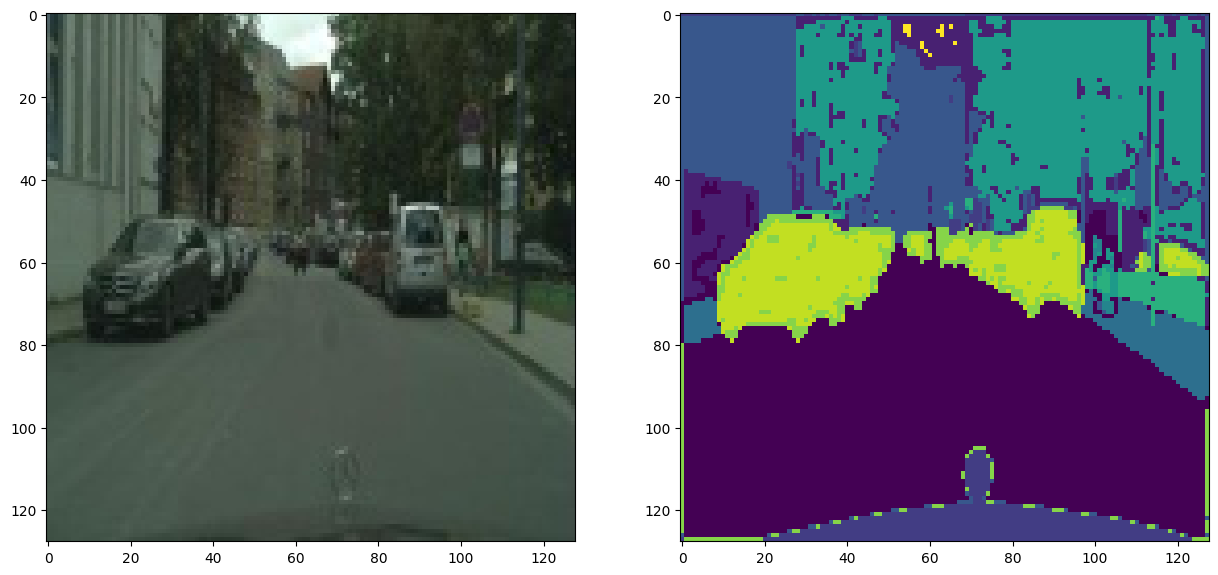

torch.Size([3, 128, 128]) torch.Size([128, 128])
tensor(1.) tensor(0.0863)
tensor(11, dtype=torch.int32) tensor(0, dtype=torch.int32)


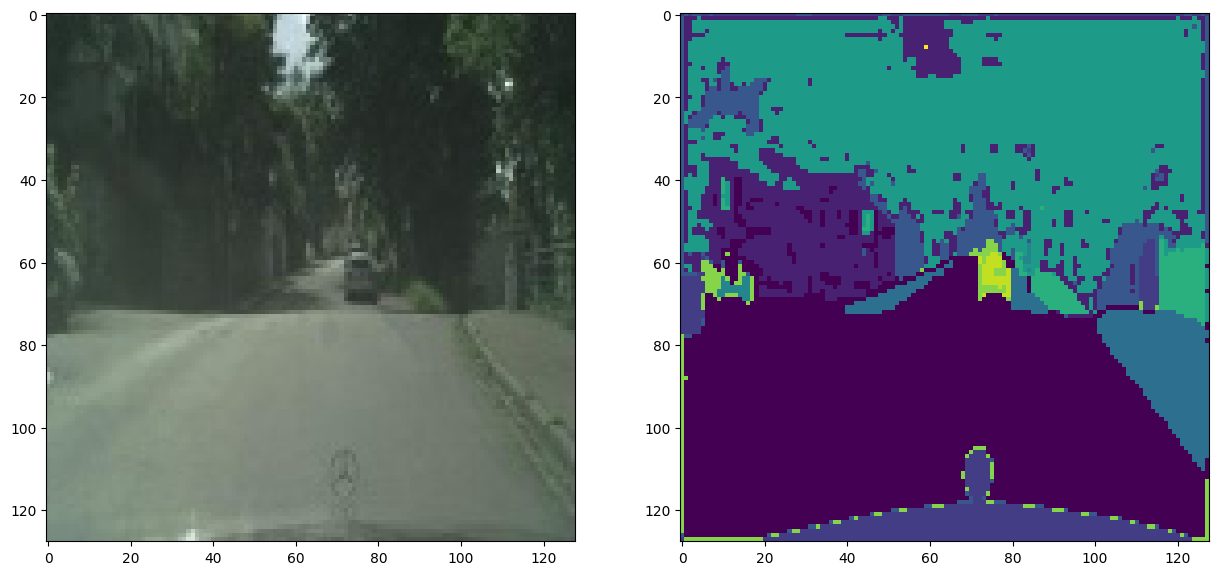

torch.Size([3, 128, 128]) torch.Size([128, 128])
tensor(0.7725) tensor(0.0078)
tensor(11, dtype=torch.int32) tensor(0, dtype=torch.int32)


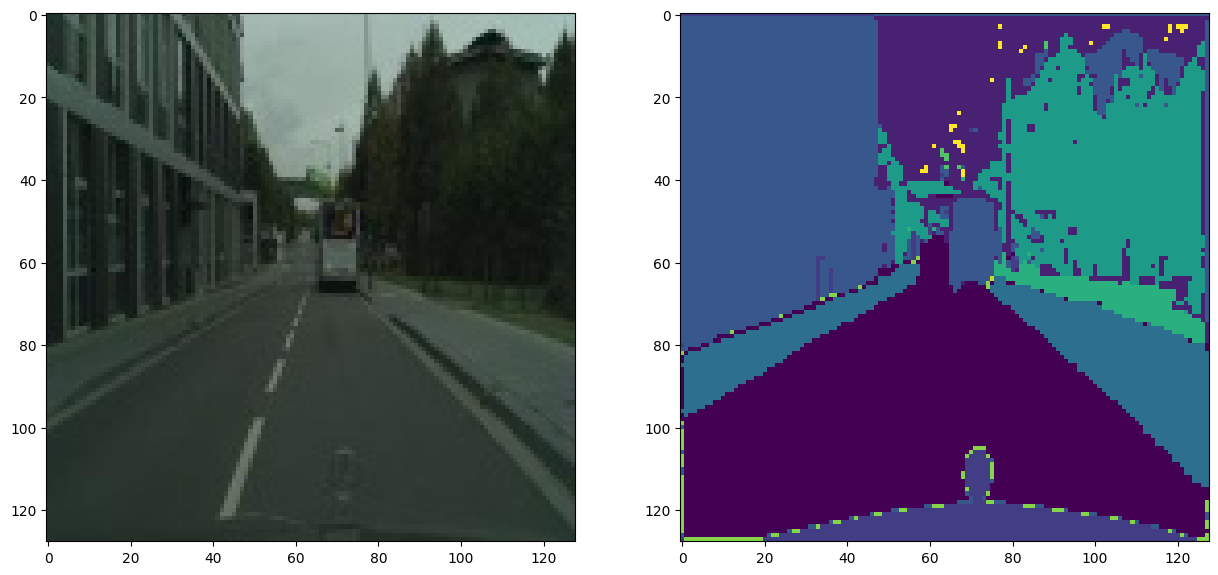

torch.Size([3, 128, 128]) torch.Size([128, 128])
tensor(0.9137) tensor(0.0275)
tensor(11, dtype=torch.int32) tensor(0, dtype=torch.int32)


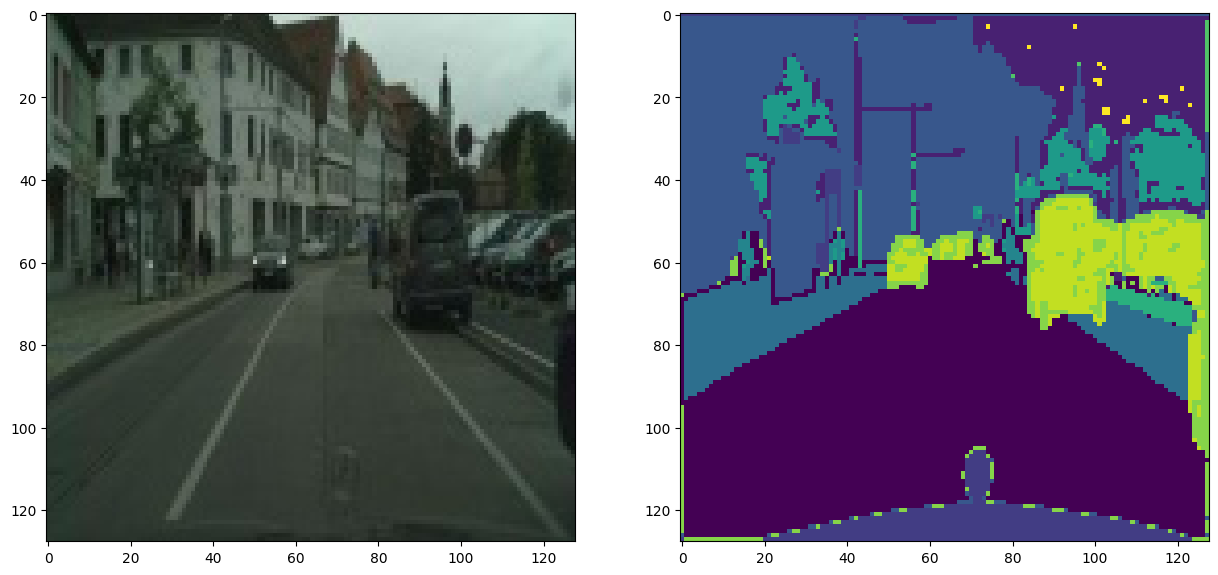

torch.Size([3, 128, 128]) torch.Size([128, 128])
tensor(1.) tensor(0.)
tensor(10, dtype=torch.int32) tensor(0, dtype=torch.int32)


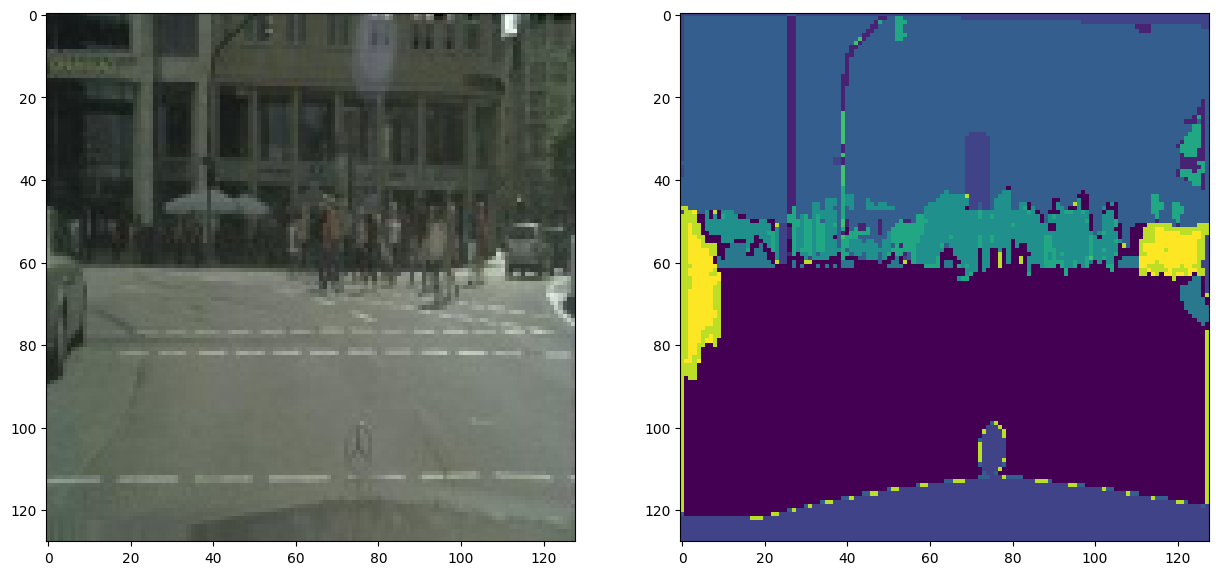

In [15]:
for i in range(5):
    img,  msk = train_data_obj.__getitem__(i)
    print(img.shape, msk.shape)
    print(img.max(), img.min())
    print(msk.max(), msk.min())
    plt.figure(figsize=(15,10))
    plt.subplot(1,2,1)
    plt.imshow(img.permute(1,2,0))
    plt.subplot(1,2,2)
    plt.imshow(msk)
    plt.show()

In [16]:
class MulticlassDiceLoss(nn.Module):

    def __init__(self, num_classes, softmax_dim=None):
        super().__init__()
        self.num_classes = num_classes
        self.softmax_dim = softmax_dim
    def forward(self, logits, targets, reduction='mean', smooth=1e-6):
        probabilities = logits
        if self.softmax_dim is not None:
            probabilities = nn.Softmax(dim=self.softmax_dim)(logits)
        # end if
        targets_one_hot = torch.nn.functional.one_hot(targets, num_classes=self.num_classes)
        # Convert from NHWC to NCHW
        targets_one_hot = targets_one_hot.permute(0, 3, 1, 2)
        
        # Multiply one-hot encoded ground truth labels with the probabilities to get the
        # prredicted probability for the actual class.
        intersection = (targets_one_hot * probabilities).sum()
        
        mod_a = intersection.sum()
        mod_b = targets.numel()
        
        dice_coefficient = 2. * intersection / (mod_a + mod_b + smooth)
        dice_loss = -dice_coefficient.log()
        return dice_loss

class SummedLoss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.dice_loss = MulticlassDiceLoss(num_classes, softmax_dim=1)
        self.cross_entropy_loss = CrossEntropyLoss()
    def forward(self, logits, targets):
        return 0.5*self.dice_loss(logits, targets) + 0.5*self.cross_entropy_loss(logits, targets)


In [17]:
model = SegNet(num_classes=OUTPUT_CLASSES)
loss_function = SummedLoss(num_classes=12)

In [18]:
trainer =  Trainer(model = model,
                  crit = loss_function,
                  train_data = train_data_obj,
                  val_data = val_data_obj,
                  val_data_a = val_data_obj_a,
                  initialize_from_ckp = None,
                  opti_name = OPIMIZER_NAME,
                  scheduler_name = SCHEDULER_NAME,
                  input_img_size = INPUT_IMG_SIZE,
                  batch_size = BATCH_SIZE,
                  out_classes = OUTPUT_CLASSES,
                  use_cuda = USE_CUDA,
                  max_epochs = MAX_EPOCHS,
                  learning_rate = LEARINING_RATE,
                  thresh_acc = THRESH_ACC_CKP,
                  step_size = SCHEDULER_STEP_SIZE
                 )

 16%|█▌        | 4/25 [04:32<23:51, 68.18s/it]

--------------------
Validation results after 5 epochs:


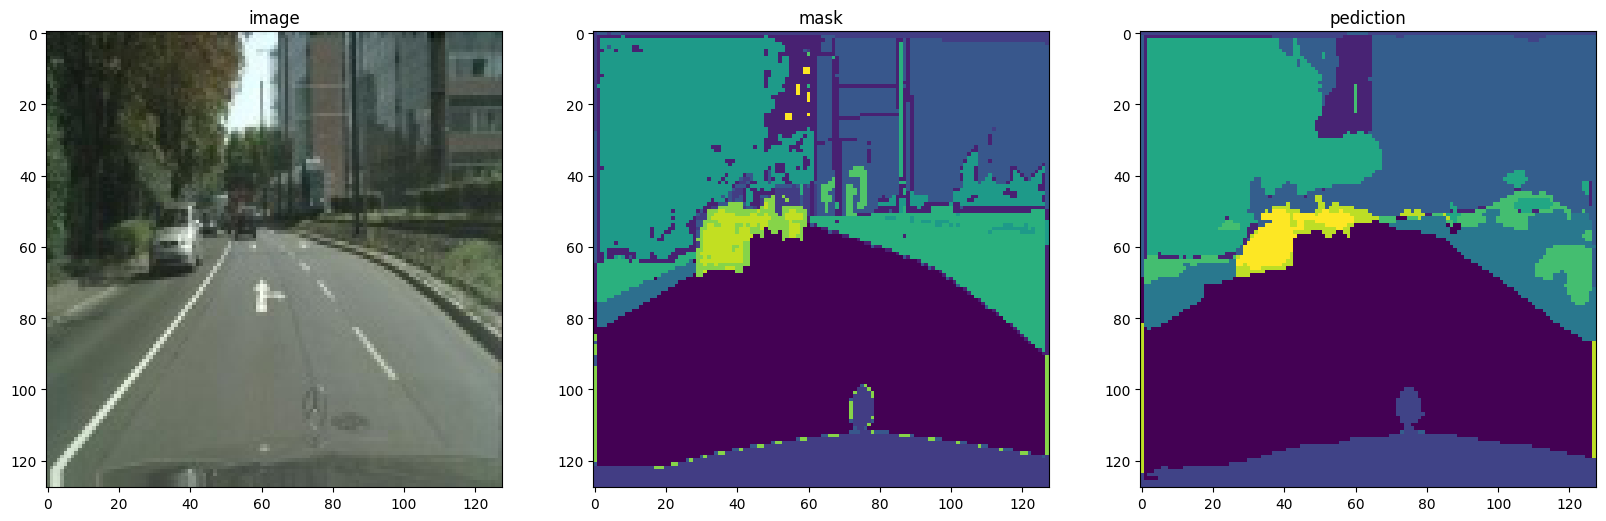

--------------------
Augmented Validation results after 5 epochs:


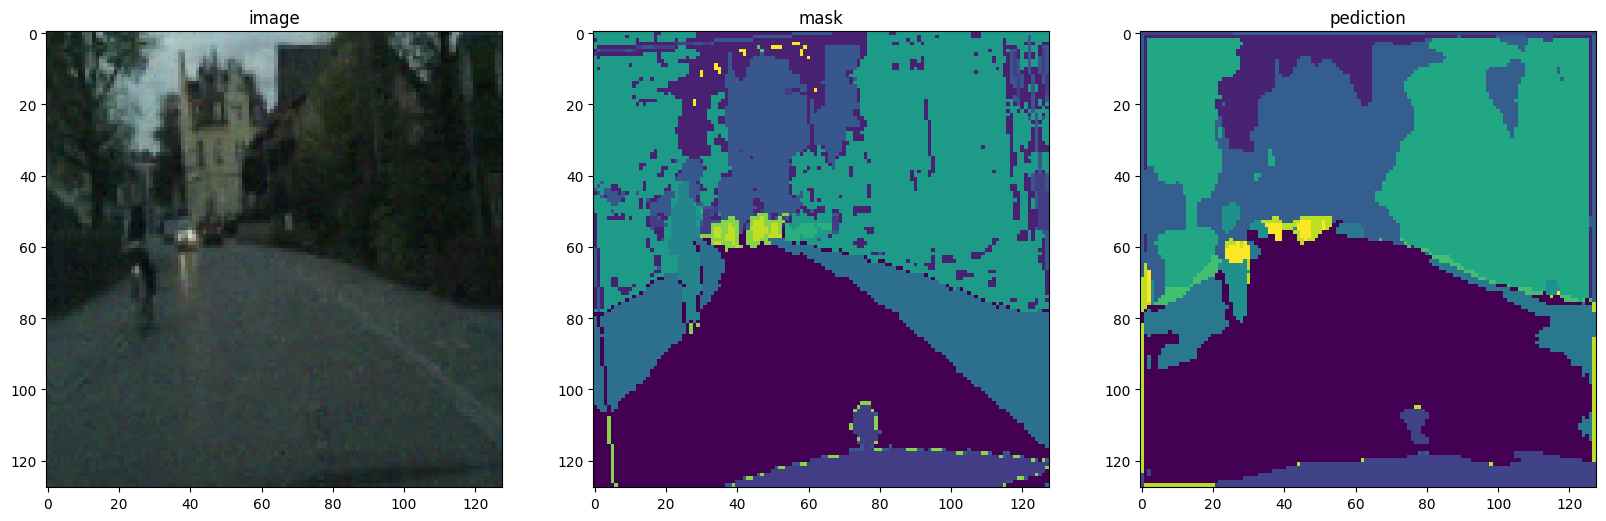

[Epochs-5/25]:
[Train_loss:0.3952 | Train_acc:0.4397 | Val_loss:0.4026 | Val_acc:0.4262] | Val_loss_a:0.6399 | Val_acc_a:0.3361


 36%|███▌      | 9/25 [10:35<18:56, 71.05s/it]

--------------------
Validation results after 10 epochs:


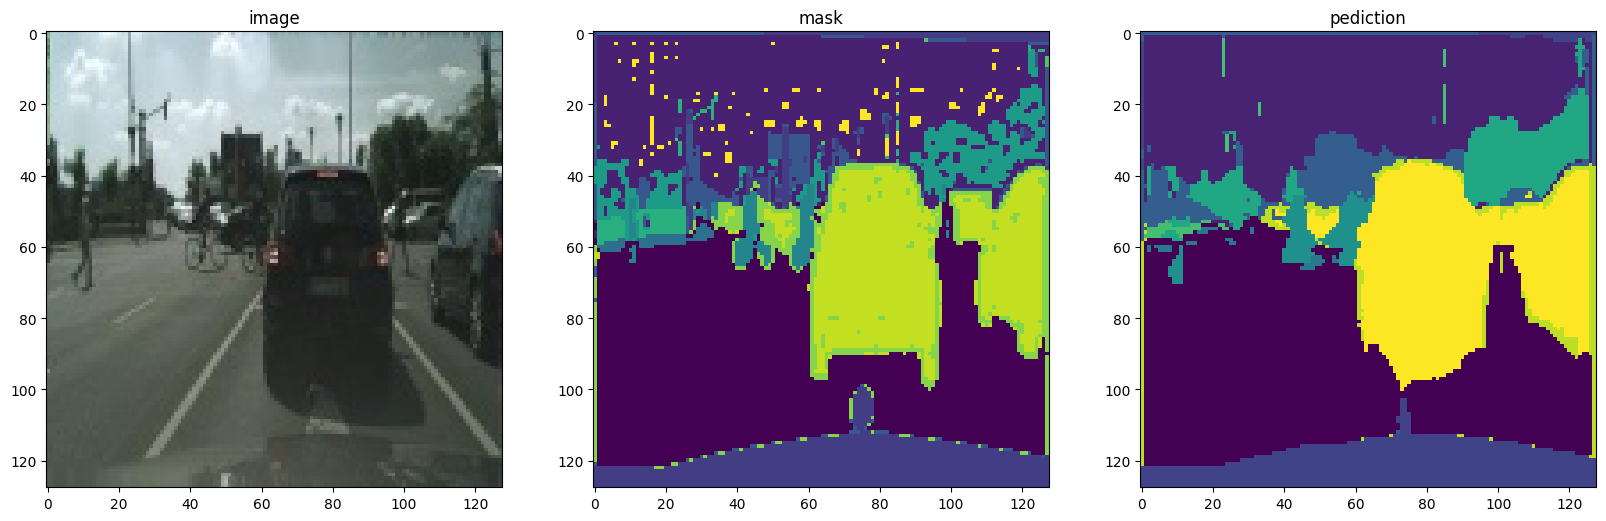

--------------------
Augmented Validation results after 10 epochs:


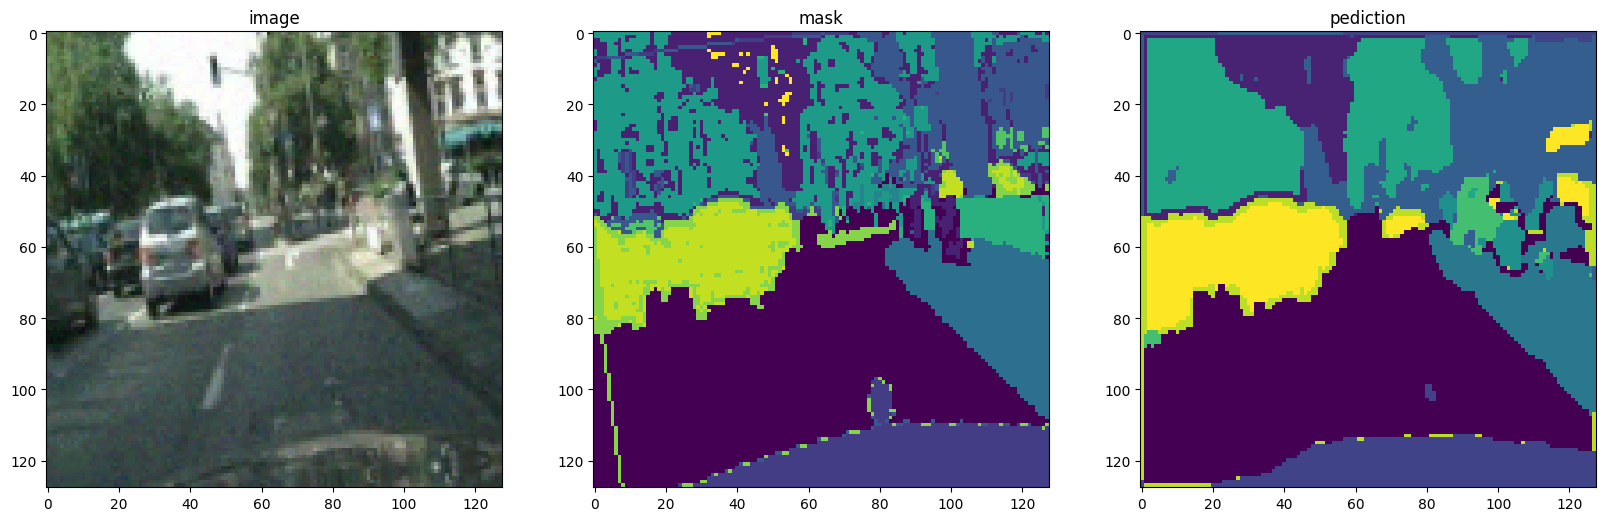

[Epochs-10/25]:
[Train_loss:0.3561 | Train_acc:0.4701 | Val_loss:0.3789 | Val_acc:0.4429] | Val_loss_a:0.6711 | Val_acc_a:0.3419


 56%|█████▌    | 14/25 [16:47<13:21, 72.84s/it]

--------------------
Validation results after 15 epochs:


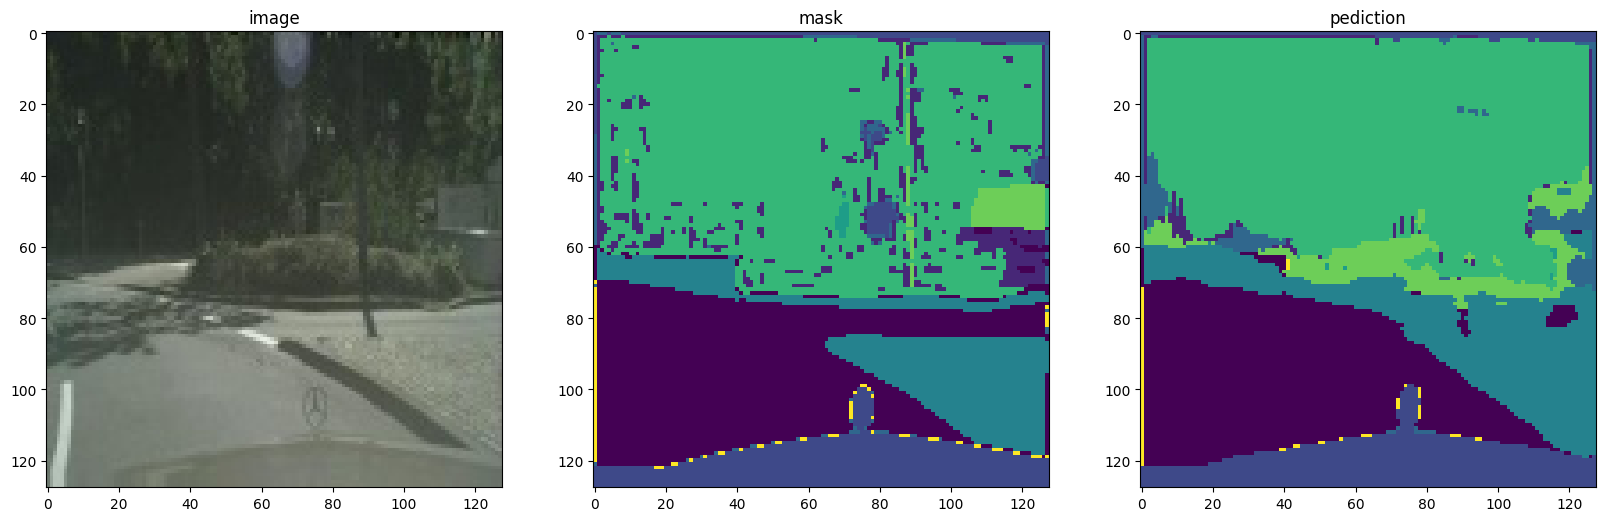

--------------------
Augmented Validation results after 15 epochs:


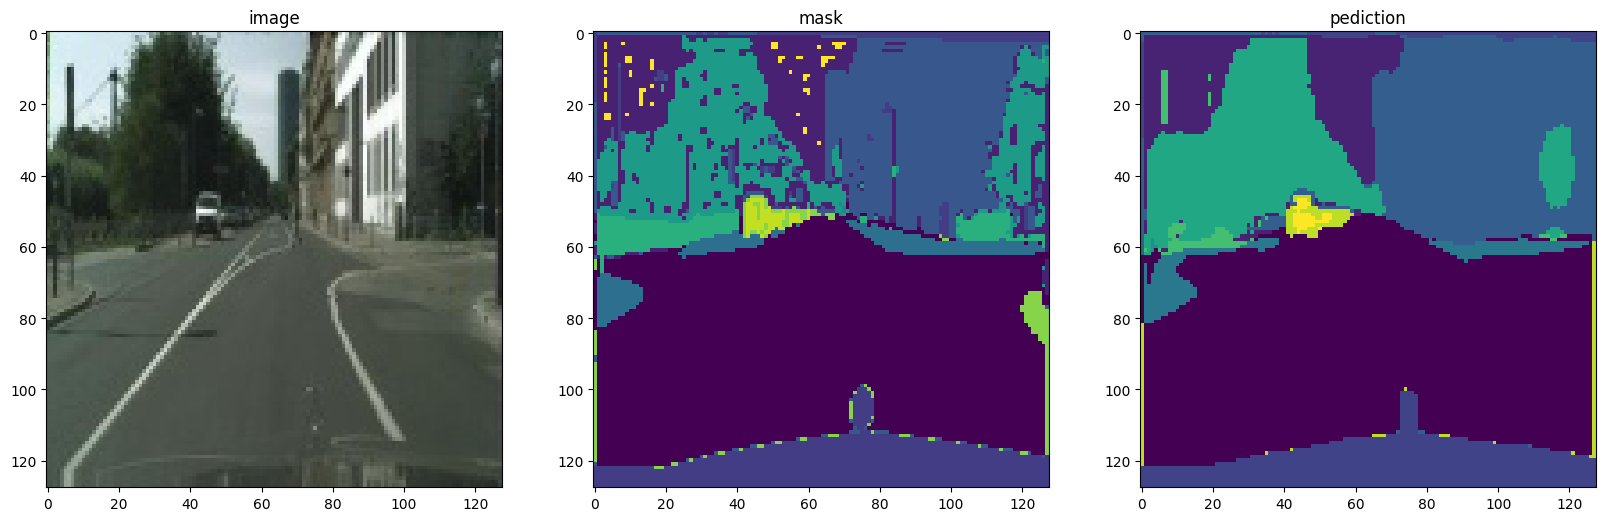

[Epochs-15/25]:
[Train_loss:0.3515 | Train_acc:0.4736 | Val_loss:0.3786 | Val_acc:0.4454] | Val_loss_a:0.6629 | Val_acc_a:0.3435


 76%|███████▌  | 19/25 [22:55<07:13, 72.32s/it]

--------------------
Validation results after 20 epochs:


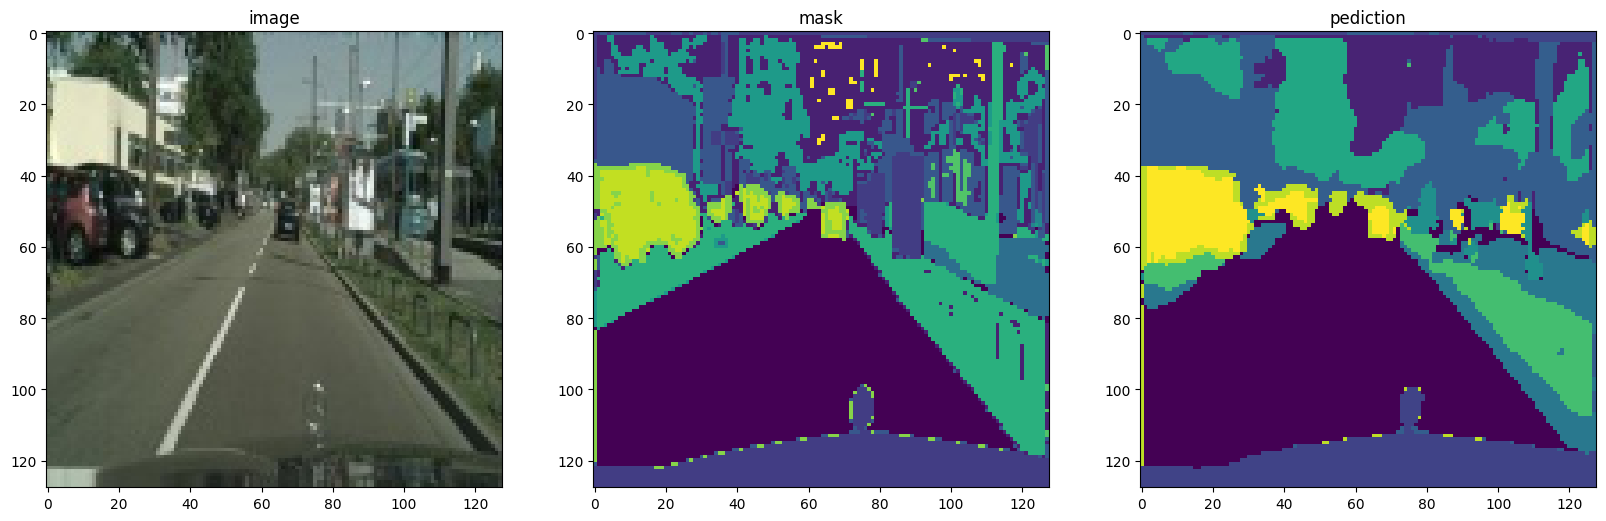

--------------------
Augmented Validation results after 20 epochs:


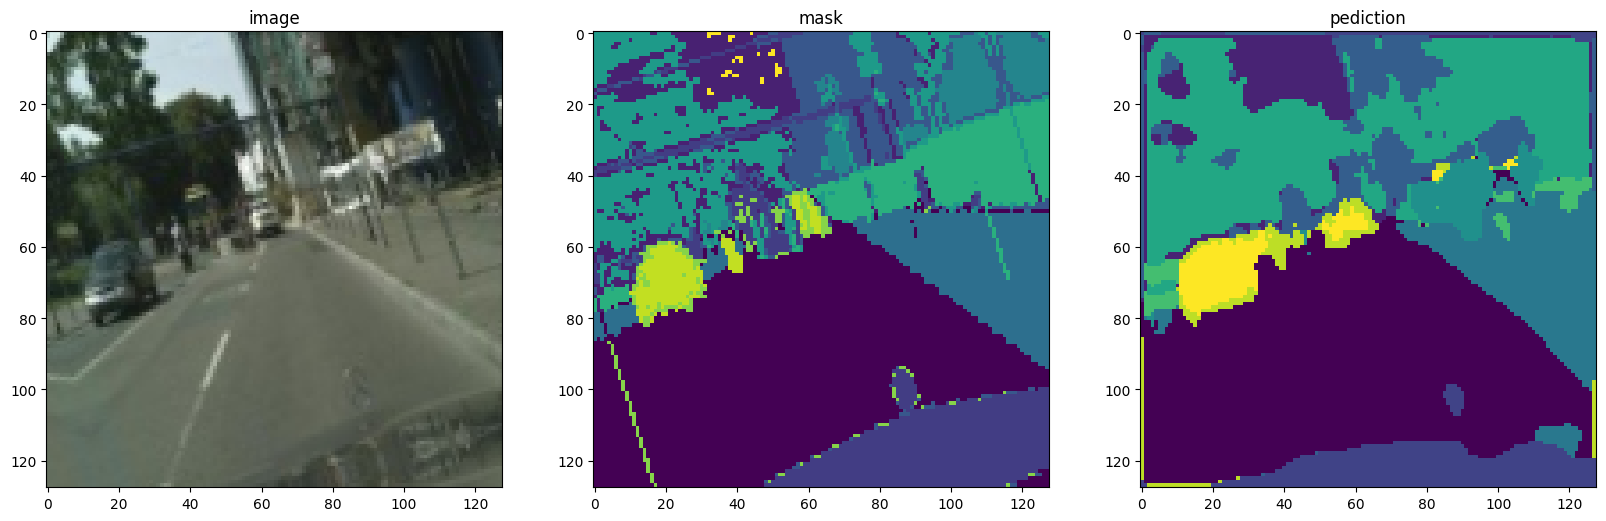

 80%|████████  | 20/25 [24:18<06:17, 75.47s/it]

[Epochs-20/25]:
[Train_loss:0.3507 | Train_acc:0.4728 | Val_loss:0.3790 | Val_acc:0.4429] | Val_loss_a:0.6693 | Val_acc_a:0.3457


 96%|█████████▌| 24/25 [29:03<01:12, 72.26s/it]

--------------------
Validation results after 25 epochs:


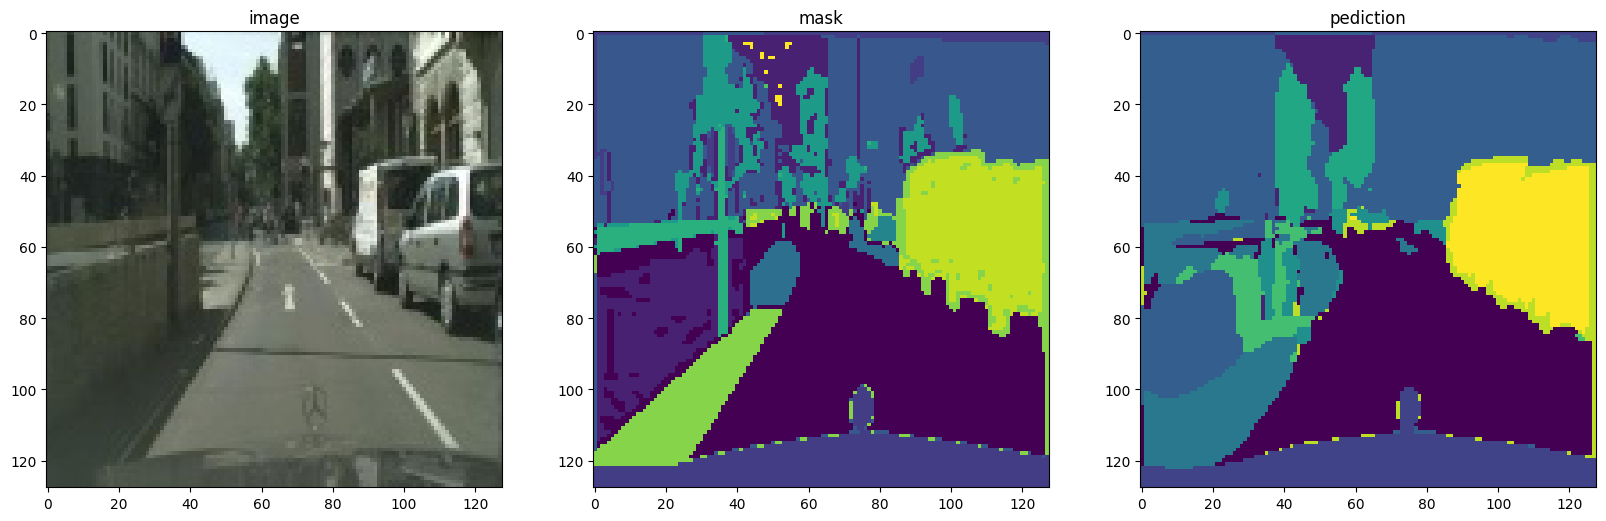

--------------------
Augmented Validation results after 25 epochs:


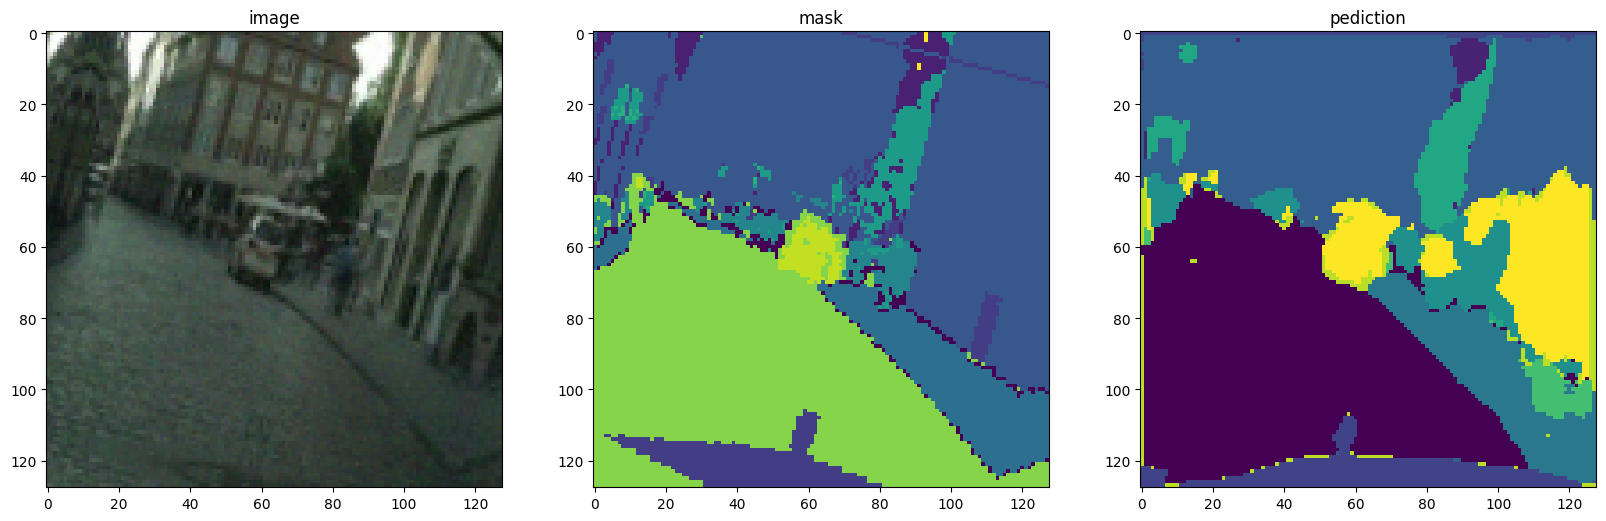

100%|██████████| 25/25 [30:26<00:00, 73.07s/it]

[Epochs-25/25]:
[Train_loss:0.3499 | Train_acc:0.4733 | Val_loss:0.3788 | Val_acc:0.4439] | Val_loss_a:0.6707 | Val_acc_a:0.3413


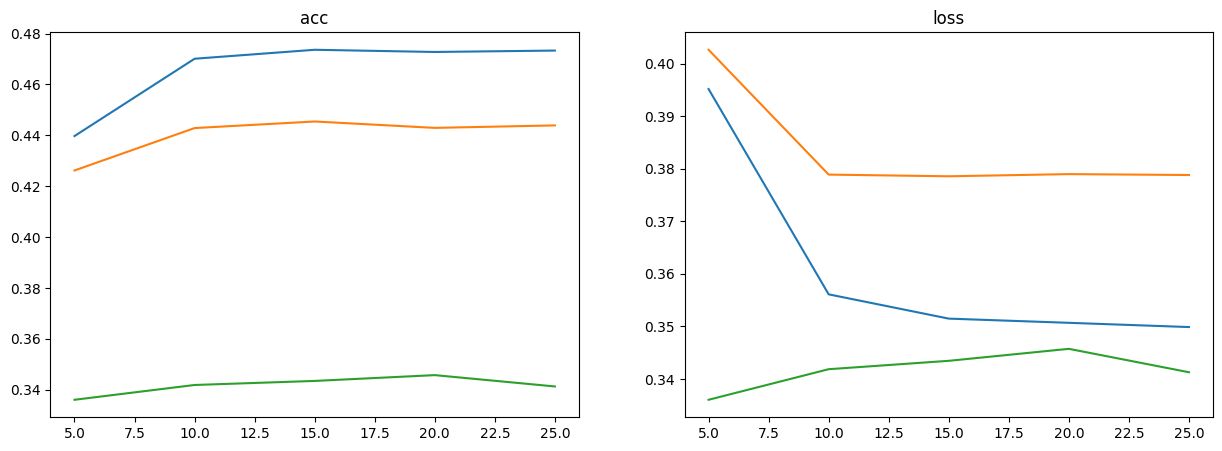

In [19]:
trainer.train()

In [20]:
# clear cache

model = None
import gc
gc.collect()
torch.cuda.empty_cache()

In [21]:
AUGMENTATION = True
train_data_obj_a = SegDataset(encoder, 128, train_files,train_files_mask, INPUT_IMG_SIZE, AUGMENTATION, mean=MEAN, std=STD)
val_data_obj_a = SegDataset(encoder, 128, test_files, test_files_mask, INPUT_IMG_SIZE, AUGMENTATION, mean=MEAN, std=STD)

In [22]:
model_a = SegNet(num_classes=OUTPUT_CLASSES)
loss_function_a = SummedLoss(num_classes=12)

  0%|          | 0/25 [00:00<?, ?it/s]

 16%|█▌        | 4/25 [05:01<26:26, 75.54s/it]

--------------------
Validation results after 5 epochs:


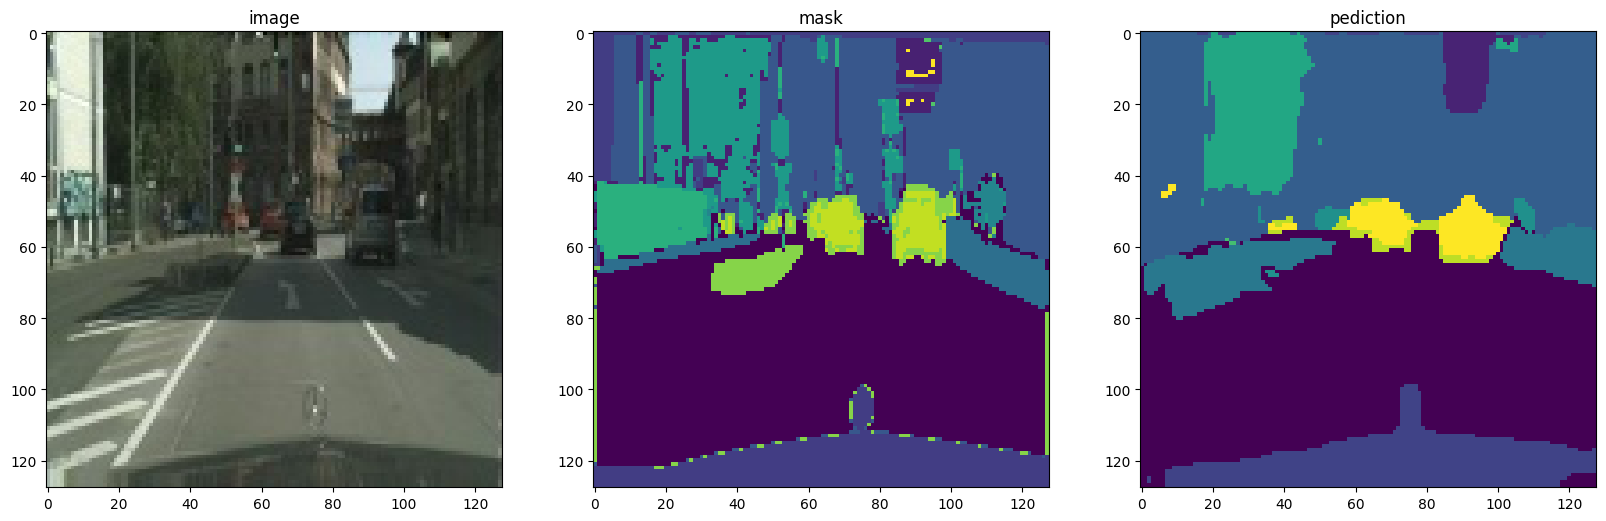

--------------------
Augmented Validation results after 5 epochs:


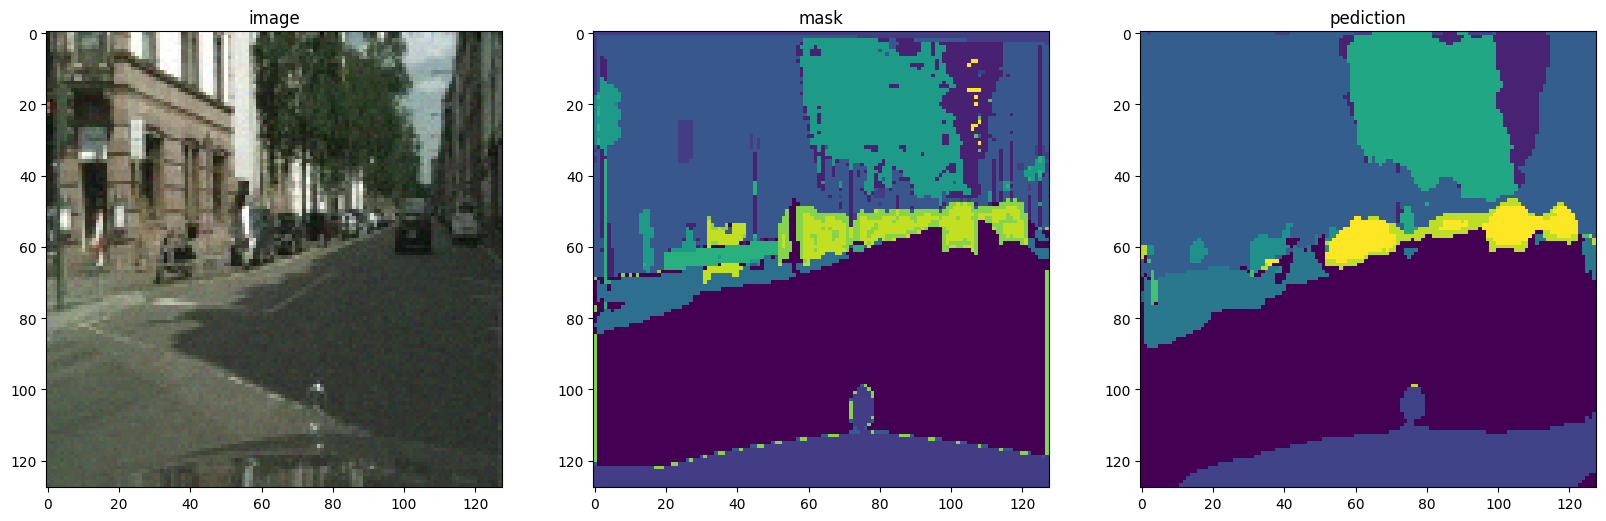

[Epochs-5/25]:
[Train_loss:0.4697 | Train_acc:0.3845 | Val_loss:0.4496 | Val_acc:0.3852] | Val_loss_a:0.4754 | Val_acc_a:0.3754


 36%|███▌      | 9/25 [11:29<20:18, 76.17s/it]

--------------------
Validation results after 10 epochs:


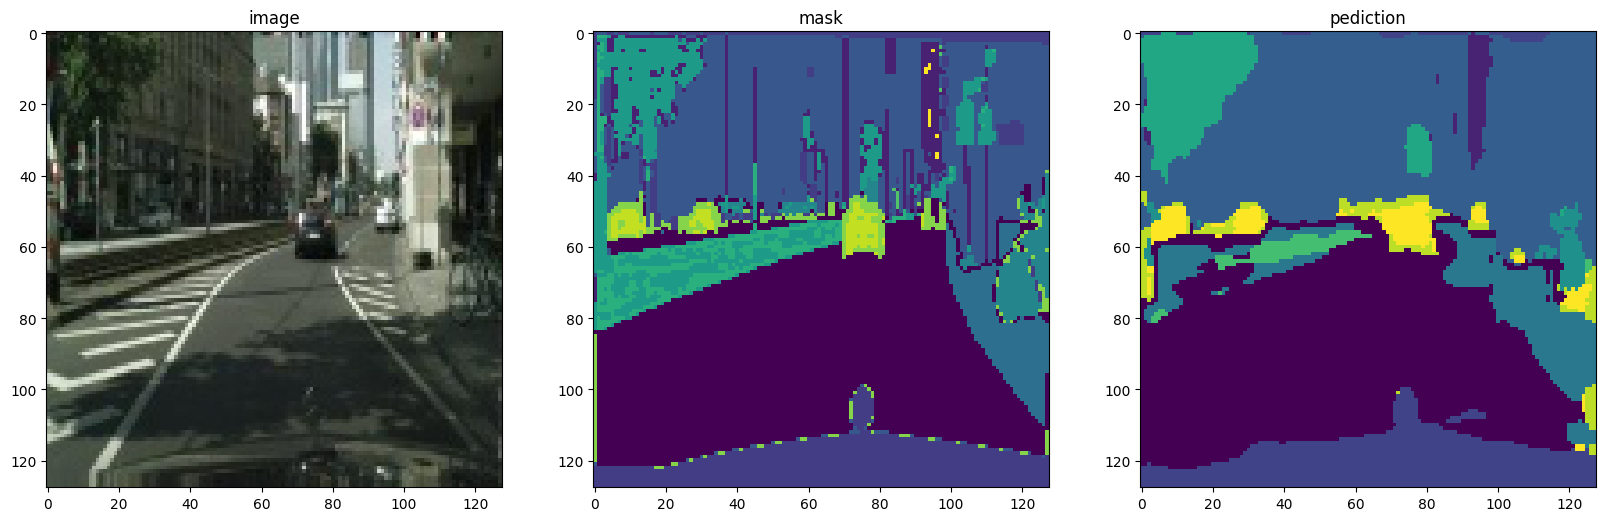

--------------------
Augmented Validation results after 10 epochs:


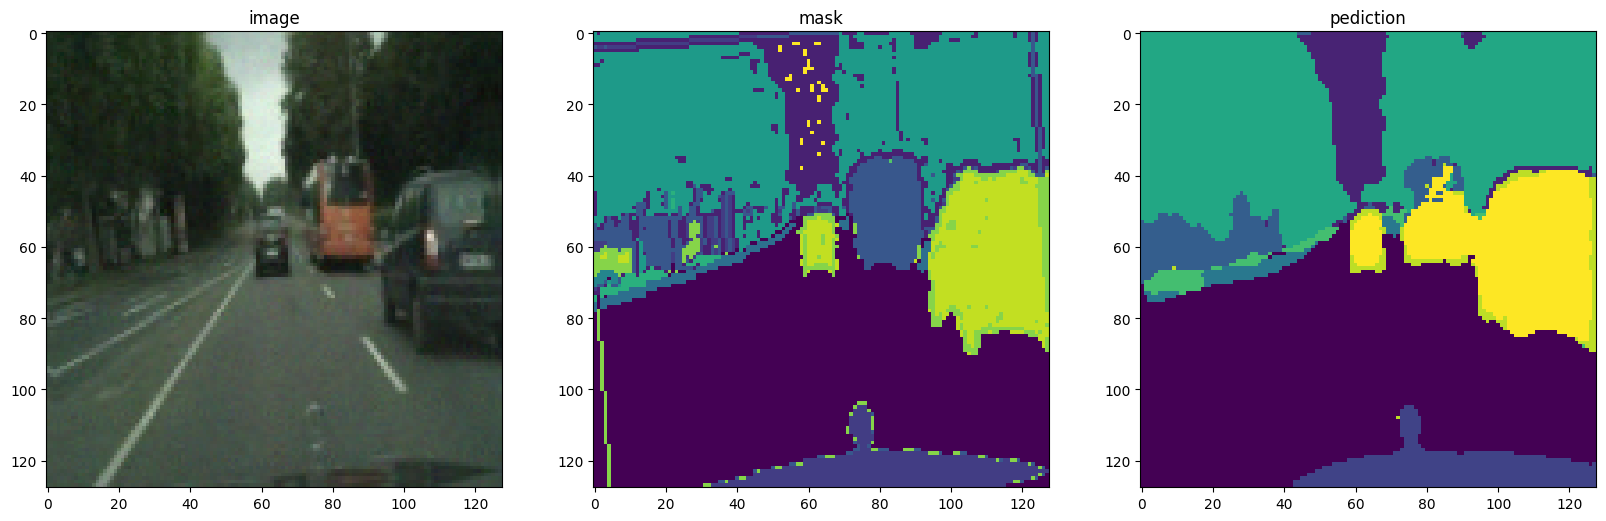

[Epochs-10/25]:
[Train_loss:0.4330 | Train_acc:0.4092 | Val_loss:0.4200 | Val_acc:0.4035] | Val_loss_a:0.4517 | Val_acc_a:0.3902


 56%|█████▌    | 14/25 [17:57<13:58, 76.21s/it]

--------------------
Validation results after 15 epochs:


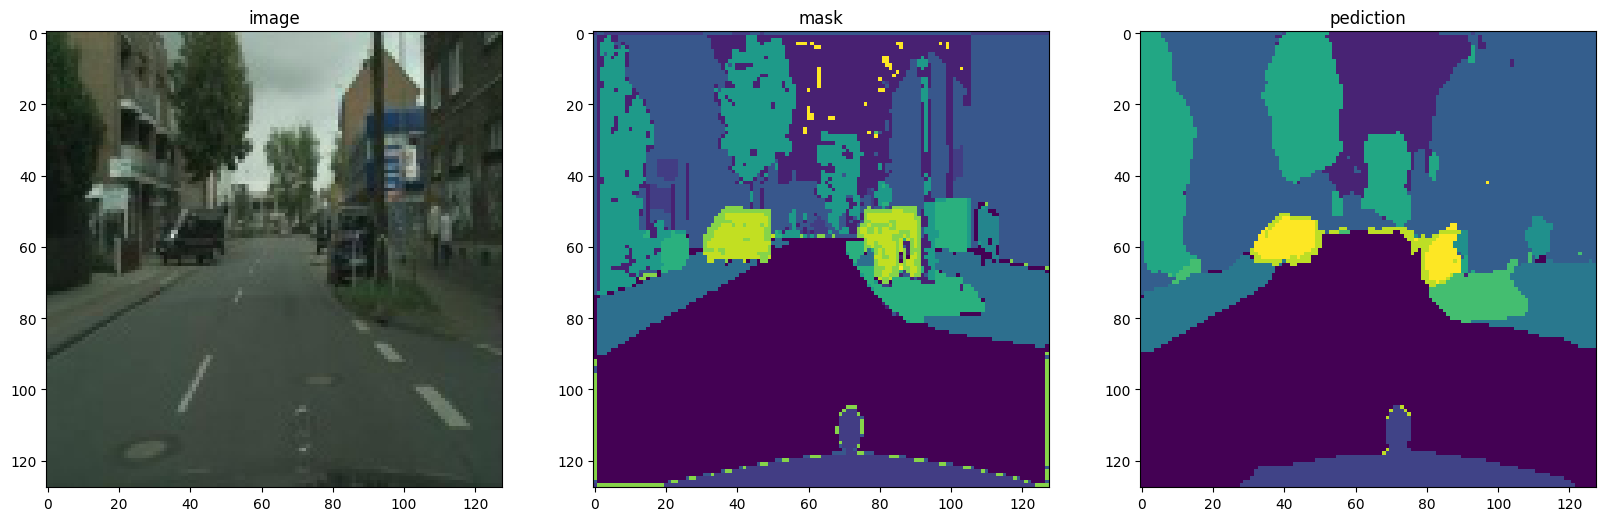

--------------------
Augmented Validation results after 15 epochs:


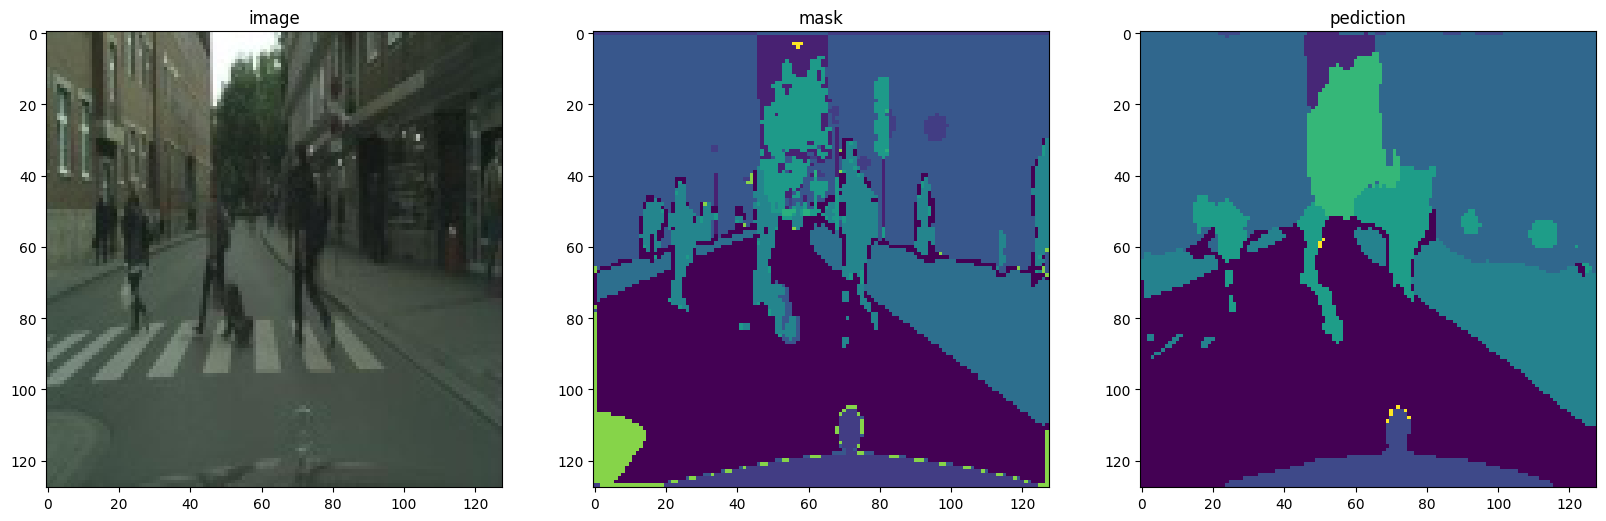

[Epochs-15/25]:
[Train_loss:0.4276 | Train_acc:0.4124 | Val_loss:0.4176 | Val_acc:0.4077] | Val_loss_a:0.4512 | Val_acc_a:0.3936


 76%|███████▌  | 19/25 [24:25<07:37, 76.19s/it]

--------------------
Validation results after 20 epochs:


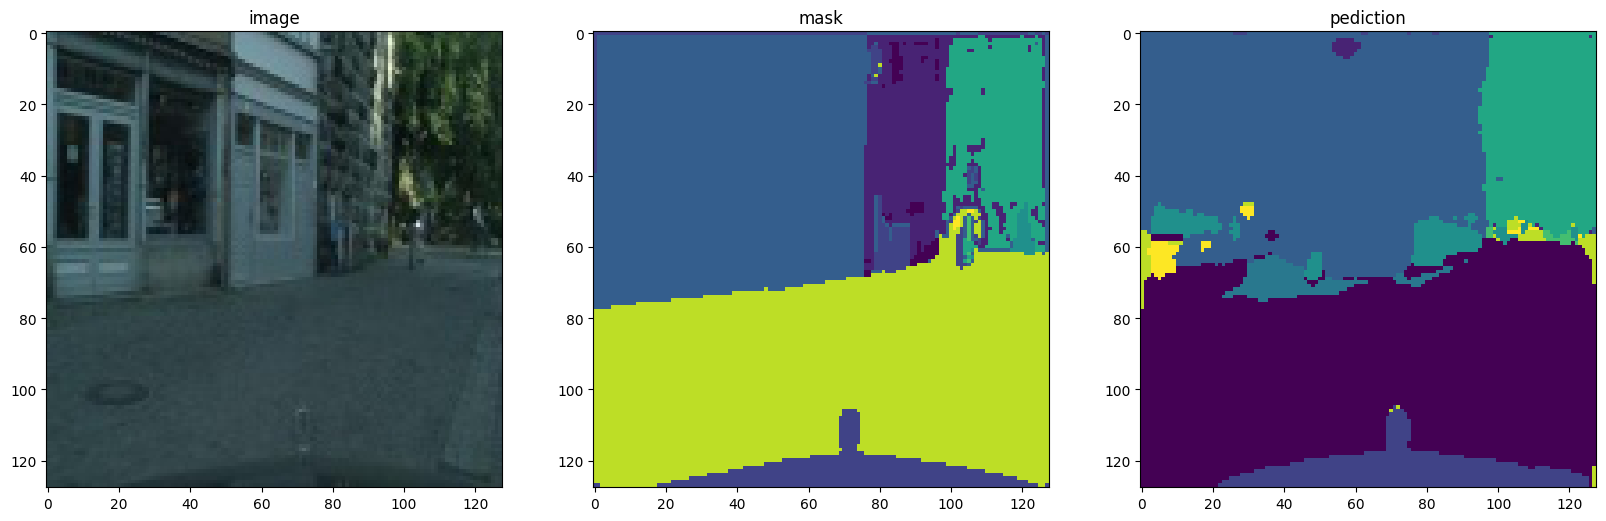

--------------------
Augmented Validation results after 20 epochs:


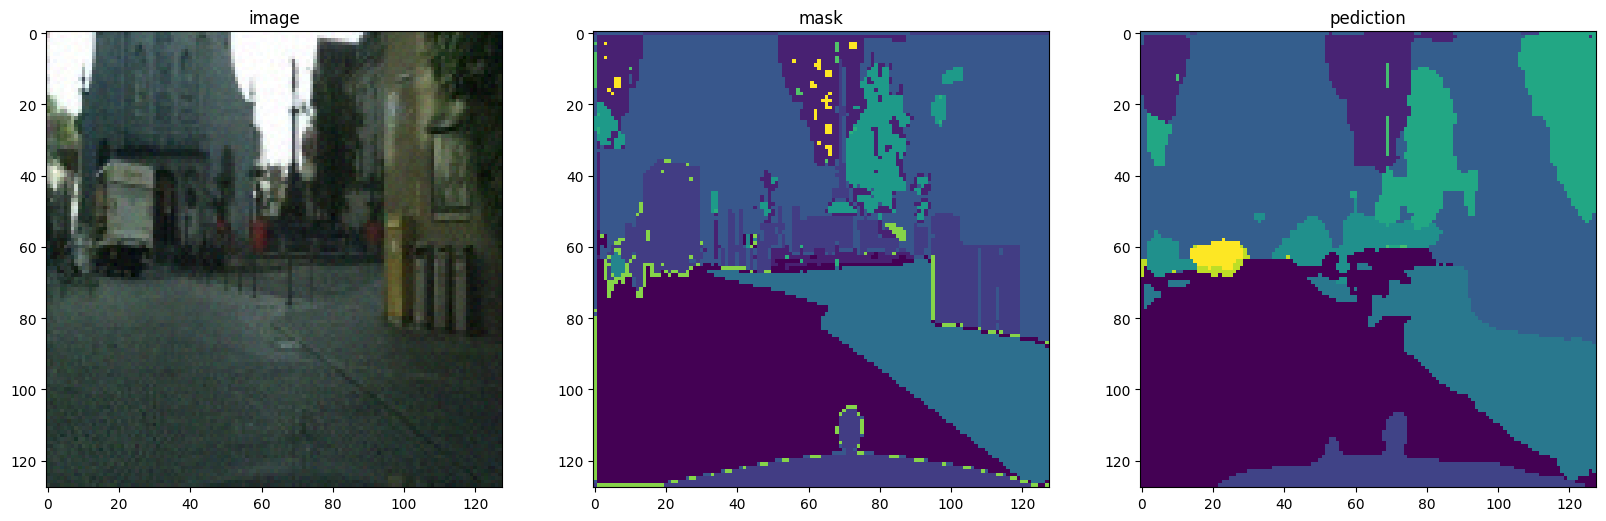

 80%|████████  | 20/25 [25:52<06:37, 79.51s/it]

[Epochs-20/25]:
[Train_loss:0.4280 | Train_acc:0.4119 | Val_loss:0.4183 | Val_acc:0.4055] | Val_loss_a:0.4491 | Val_acc_a:0.3936


 96%|█████████▌| 24/25 [30:53<01:16, 76.25s/it]

--------------------
Validation results after 25 epochs:


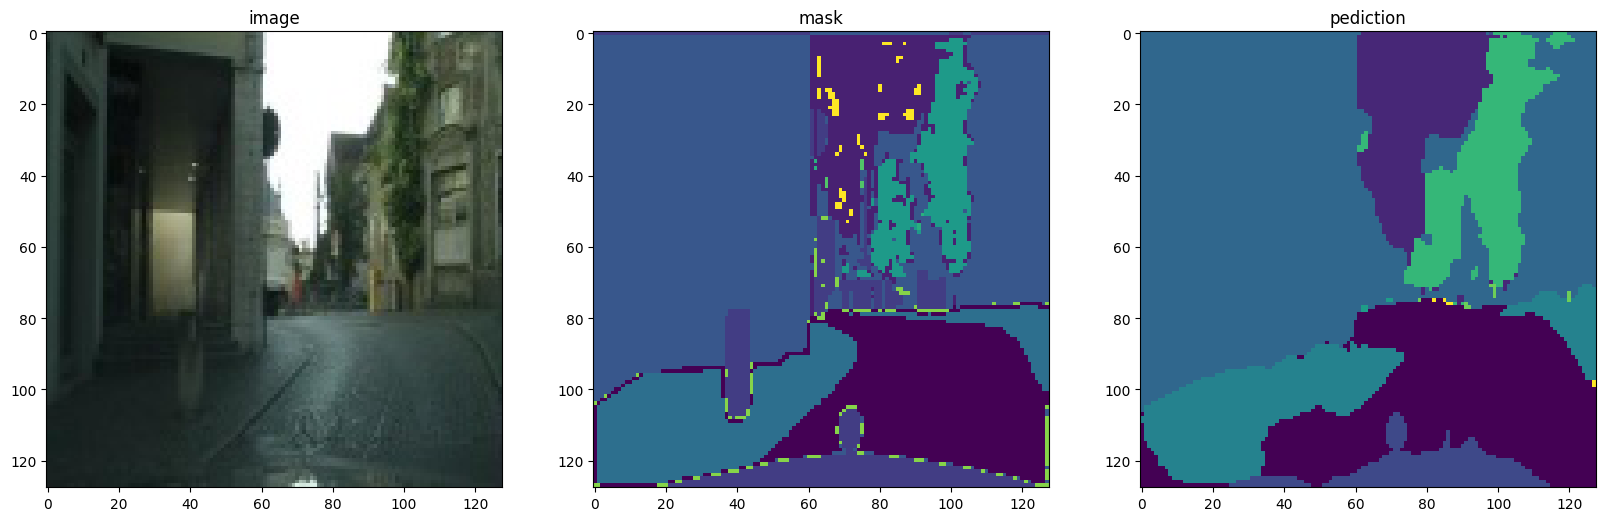

--------------------
Augmented Validation results after 25 epochs:


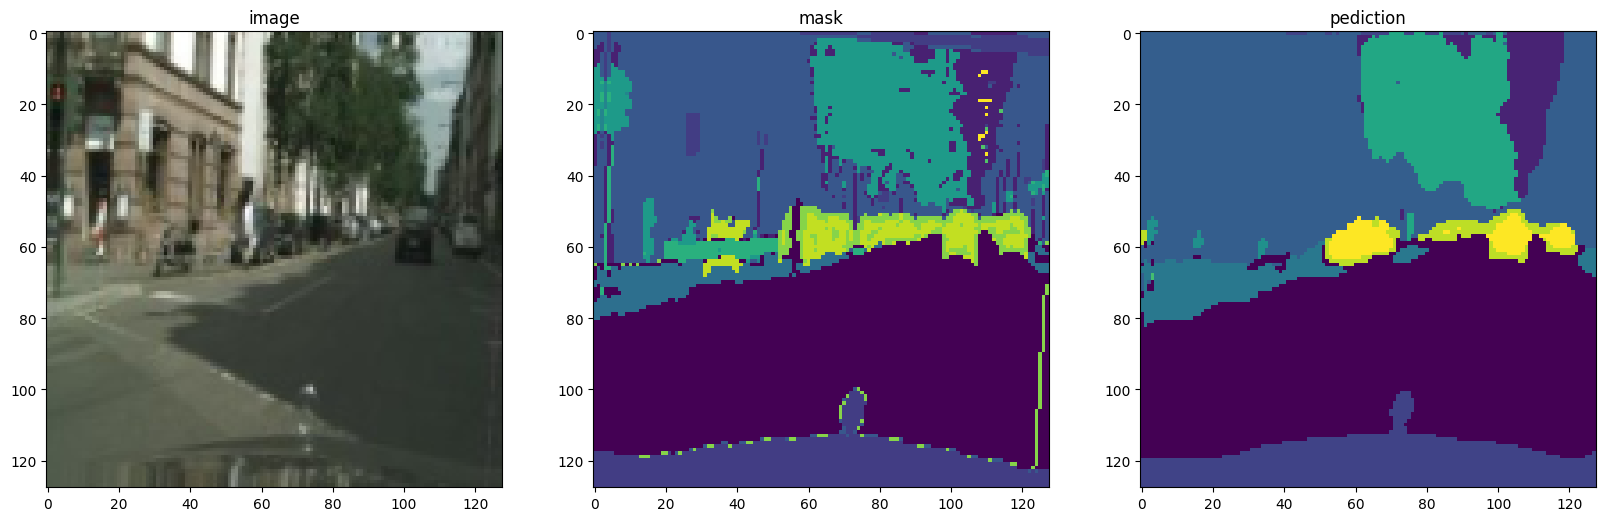

100%|██████████| 25/25 [32:20<00:00, 77.64s/it]

[Epochs-25/25]:
[Train_loss:0.4288 | Train_acc:0.4115 | Val_loss:0.4175 | Val_acc:0.4065] | Val_loss_a:0.4481 | Val_acc_a:0.3939


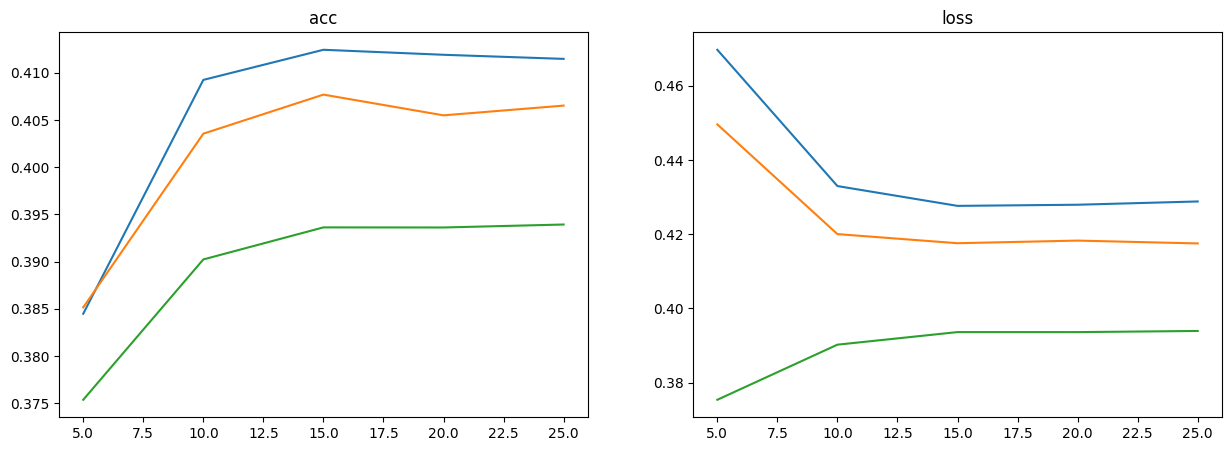

In [23]:
trainer_a =  Trainer(model = model_a,
                  crit = loss_function_a,
                  train_data = train_data_obj_a,
                  val_data = val_data_obj,
                  val_data_a = val_data_obj_a,
                  initialize_from_ckp = None,
                  opti_name = OPIMIZER_NAME,
                  scheduler_name = SCHEDULER_NAME,
                  input_img_size = INPUT_IMG_SIZE,
                  batch_size = BATCH_SIZE,
                  out_classes = OUTPUT_CLASSES,
                  use_cuda = USE_CUDA,
                  max_epochs = MAX_EPOCHS,
                  learning_rate = LEARINING_RATE,
                  thresh_acc = THRESH_ACC_CKP,
                  step_size = SCHEDULER_STEP_SIZE
                 )
trainer_a.train()

In [24]:
# clear cache

model = None
import gc
gc.collect()
torch.cuda.empty_cache()

In [13]:
# Write data preprocessing code for streamlit app

import streamlit as st
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
from torch import from_numpy
from torch.nn import DataParallel
import torch.nn as nn
import albumentations as A
from torchinfo import summary
import matplotlib.pyplot as plt

# Hyper Params
INPUT_IMG_SIZE = 128
OUTPUT_CLASSES = 12
LEARINING_RATE = 0.003
OPIMIZER_NAME = 'Adam'
SCHEDULER_NAME = 'stepLR'
BATCH_SIZE = 8
MAX_EPOCHS = 25
AUGMENTATION = False
MEAN = None
STD = None
THRESH_ACC_CKP = 0.35
SCHEDULER_STEP_SIZE = 4
USE_CUDA = torch.cuda.is_available()

# Model
class SegNet(nn.Module):
    def __init__(self, num_classes):
        super(SegNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=256, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)




    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block

    def forward(self, X):

        contracting_11_out = self.contracting_11(X)
        contracting_12_out = self.contracting_12(contracting_11_out)
        contracting_21_out = self.contracting_21(contracting_12_out)
        contracting_22_out = self.contracting_22(contracting_21_out)
        contracting_31_out = self.contracting_31(contracting_22_out)
        contracting_32_out = self.contracting_32(contracting_31_out)

        middle_out = self.middle(contracting_32_out)

        expansive_11_out = self.expansive_11(middle_out)
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_31_out), dim=1))
        expansive_21_out = self.expansive_21(expansive_12_out)
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_21_out), dim=1))
        expansive_31_out = self.expansive_31(expansive_22_out)
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_11_out), dim=1))

        output_out = self.output(expansive_32_out)
        return output_out


# Load model
model = SegNet(OUTPUT_CLASSES)
model = DataParallel(model)
model.load_state_dict(torch.load('results_1/02-11-2023 [01.02.06]/epoch_20_val_acc [0.461]/checkpoint.ckp')['state_dict'])
model.cuda()
model.eval()

# Load encoder
import pickle
with open('encoder.pkl', 'rb') as f:
    encoder = pickle.load(f)

# Load image
uploaded_file = st.file_uploader("Choose an image...", type="jpg")

transform = A.Compose([A.Resize(INPUT_IMG_SIZE, INPUT_IMG_SIZE)])


# Test image
img = plt.imread('segdata128/reduced/val/2.jpg')
img = (transform(image=img)['image']).astype(np.float32)
print(img)
img = from_numpy(img).permute(2, 0, 1)
img = img.unsqueeze(0)
pred = model(img)
pred = pred.squeeze(0)
pred = np.argmax(pred.detach().cpu().numpy(), axis=0)
pred = encoder.cluster_centers_[pred]
pred = pred.reshape(INPUT_IMG_SIZE, INPUT_IMG_SIZE, 3)
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(img.squeeze(0).permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(pred)
plt.show()



[[[160 172 150]
  [165 176 162]
  [242 252 244]
  ...
  [ 56  65  44]
  [ 72  83  66]
  [191 202 188]]

 [[143 155 131]
  [195 206 192]
  [246 255 248]
  ...
  [ 65  74  53]
  [ 96 107  90]
  [203 214 200]]

 [[124 137 109]
  [218 229 212]
  [243 253 244]
  ...
  [ 74  83  62]
  [123 134 118]
  [214 225 211]]

 ...

 [[ 62  73  57]
  [ 64  75  59]
  [ 61  72  56]
  ...
  [ 37  44  36]
  [ 37  44  37]
  [ 50  55  49]]

 [[ 62  73  57]
  [ 65  76  60]
  [ 60  71  55]
  ...
  [ 41  48  40]
  [ 40  47  39]
  [ 52  57  51]]

 [[ 62  73  57]
  [ 65  76  60]
  [ 60  71  55]
  ...
  [ 45  52  44]
  [ 43  50  42]
  [ 51  58  50]]]


RuntimeError: Input type (unsigned char) and bias type (float) should be the same